# 멀티센서 input을 이용한 SPR 접합특성 분류

In [51]:
#Input data loading
import numpy as np

from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics

from keras.models import Model
from keras import layers
from keras import Input

import matplotlib.pyplot as plt

In [52]:
#기본 데이터 로드--------------------------------------------------------------

#Displacement data loading
_Displacement_path = "C:/Temp/displacement13.csv"
Displacement_original_Data = np.loadtxt(_Displacement_path, delimiter=',', dtype=np.float32, encoding='utf-8')

#Load data loading
_Load_path = "C:/Temp/load13.csv"
Load_original_Data = np.loadtxt(_Load_path, delimiter=',', dtype=np.float32, encoding='utf-8')

#Acoustic data loading - 15000개 데이터 중 7500개만 사용
_Acoustic_path = "C:/Temp/Acoustic.csv"
Acoustic_original_Data = np.loadtxt(_Acoustic_path, delimiter=',', dtype=np.float32, encoding='utf-8')

Acoustic_original_Data = Acoustic_original_Data[:,:7500]


#Output data loading
_Class_result_path = "C:/Temp/Class_result.csv"
Class_result_original_Data = np.loadtxt(_Class_result_path, delimiter=',', dtype=np.int32, encoding='utf-8')

#Checking Data amount
Dispaldement_data_shape = Displacement_original_Data.shape
Load_data_shape = Load_original_Data.shape
Acoustic_data_shape = Acoustic_original_Data.shape
Class_result_Data_shape = Class_result_original_Data.shape

print (Dispaldement_data_shape)
print (Load_data_shape)
print (Acoustic_data_shape)
print (Class_result_Data_shape)

(130, 248)
(130, 248)
(130, 7500)
(130, 13)


In [53]:

#데이터 표준화--------------------------------------------------------------
Displacement_original_Data -= Displacement_original_Data.mean(axis=0)
Displacement_original_Data /= Displacement_original_Data.std(axis=0)

Load_original_Data -= Load_original_Data.mean(axis=0)
Load_original_Data /= Load_original_Data.std(axis=0)

Acoustic_original_Data -= Acoustic_original_Data.mean(axis=0)
Acoustic_original_Data /= Acoustic_original_Data.std(axis=0)

Displacement_norm_Data = Displacement_original_Data
Load_norm_Data = Load_original_Data
Acoustic_norm_Data = Acoustic_original_Data


In [43]:

#데이터 총 개수 확인--------------------------------------------------------------
Data_amount = Class_result_Data_shape[0]

print(Data_amount)


130


In [54]:
#데이터 합치기 1x248 2개의 데이터를 이미지 처럼 2x248 데이터로------------------------

#Initializing
Input_data = []

#Merging each line
for i in range(Data_amount):

    Input_data.append(np.stack([Displacement_norm_Data[i,:], Load_norm_Data[i,:]]))

Input_data = np.array(Input_data)    
print(Input_data.shape)


(130, 2, 248)


In [55]:
#Acoustic data 다운 샘플링 10개 평균 7500개 -> 750개 데이터------------------------

Input_data2 = np.zeros((130,750))

for i in range(130):
    for j in range(750):
        Input_data2[i][j] = np.mean(Acoustic_norm_Data[i][j*10:j*10+10])

Input_data2 = np.array(Input_data2)
print(Input_data2.shape)

(130, 750)


In [56]:
#CNN을 위한 입력 데이터 리사이징---------------------------------------------------
Input_data = Input_data.reshape((130,2,248,1))
Input_data2 = Input_data2.reshape((130,750,1))

#출력 데이터 확인--------------------------------------------------------------
Output_data = np.array(Class_result_original_Data)
print(Output_data.shape)

(130, 13)


In [57]:
#입력 데이터 70:15:15로 나누기(Training, validation, test)------------------
#Displacement and Load

# split data: Training data를 70%
x_train, x_test, y_train, y_test = train_test_split(Input_data, Output_data, 
				       train_size=0.70, random_state=42)
# split data: Validation과 Test data를 50:50 으로
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, 
				       train_size=0.50, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train)

(91, 2, 248, 1)
(91, 13)
(19, 2, 248, 1)
(19, 13)
(20, 2, 248, 1)
(20, 13)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [58]:
#Acoustic

# split data: Training data를 70%
x2_train, x2_test, y_train, y_test = train_test_split(Input_data2, Output_data, 
				       train_size=0.70, random_state=42)
# split data: Validation과 Test data를 50:50 으로
x2_val, x2_test, y_val, y_test = train_test_split(x2_test, y_test, 
				       train_size=0.50, random_state=42)
print(x2_train.shape)
print(y_train.shape)
print(x2_val.shape)
print(y_val.shape)
print(x2_test.shape)
print(y_test.shape)
print(y_train)


(91, 750, 1)
(91, 13)
(19, 750, 1)
(19, 13)
(20, 750, 1)
(20, 13)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [59]:
#모델 구조 설계 및 컴파일러 설정------------------

X1 = Input(shape=(2, 248, 1), dtype='float32')
X2 = Input(shape=(750, 1), dtype='float32')

Model_1_1 = layers.Conv2D(64, (2, 10), activation='relu', input_shape=(2, 248, 1))(X1)
Model_1_2 = layers.MaxPooling2D((1, 4))(Model_1_1)
Model_1_3 = layers.Flatten()(Model_1_2)

Model_2_1 = layers.Conv1D(64, 10, activation='relu', input_shape=(750, 1))(X2)
Model_2_2 = layers.MaxPooling1D((4))(Model_2_1)
Model_2_3 = layers.Flatten()(Model_2_2)

concatenated = layers.concatenate([Model_1_3, Model_2_3], axis=-1)
answer = layers.Dense(13, activation='softmax')(concatenated)

model = Model([X1, X2], answer)

model.summary()

model.compile(optimizer='adam',
 loss='categorical_crossentropy',
 metrics=['accuracy'])


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2, 248, 1)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 750, 1)]     0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 1, 239, 64)   1344        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 741, 64)      704         input_10[0][0]                   
____________________________________________________________________________________________

Epoch 1/40
19/19 [==============================] - 1s 17ms/step - loss: 2.6795 - accuracy: 0.2146 - val_loss: 2.3378 - val_accuracy: 0.2105
Epoch 2/40
19/19 [==============================] - 0s 7ms/step - loss: 0.9868 - accuracy: 0.6307 - val_loss: 1.2947 - val_accuracy: 0.5789
Epoch 3/40
19/19 [==============================] - 0s 6ms/step - loss: 0.6110 - accuracy: 0.8311 - val_loss: 1.1001 - val_accuracy: 0.6842
Epoch 4/40
19/19 [==============================] - 0s 6ms/step - loss: 0.2497 - accuracy: 0.9783 - val_loss: 0.8609 - val_accuracy: 0.7368
Epoch 5/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0951 - accuracy: 1.0000 - val_loss: 1.0339 - val_accuracy: 0.6842
Epoch 6/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 0.8770 - val_accuracy: 0.7368
Epoch 7/40
19/19 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.8695 - val_accuracy: 0.7368
Epoch 8/40
19/19 [=

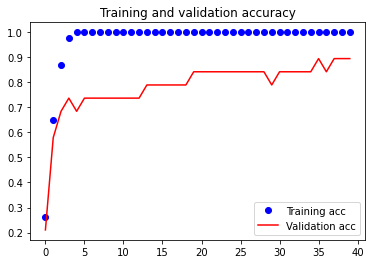

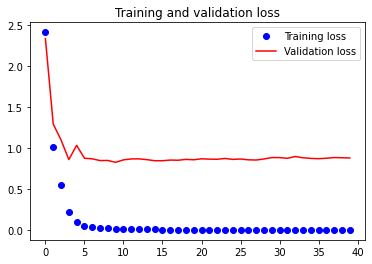

In [34]:
#학습 시작-------------------------------
history = model.fit([x_train, x2_train], y_train, epochs=40, batch_size=5, validation_data=([x_val, x2_val], y_val))


#train, val acc and loss graph-------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [35]:
#train, val Confusion matrix-------------------------------
#train data 검사
predictions = model.predict([x_train,x2_train])
y_pred = (predictions > 0.5)
matrix = sklearn.metrics.confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion Matrix")
print(matrix)
print("Target")
print(y_train.argmax(axis=1))
print("Prediction")
print(y_pred.argmax(axis=1))


Confusion Matrix
[[8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 8]]
Target
[ 2  4  6  9  3  6 12  0  3  6  2 11  2  9 12  5  0  6  7  3  4  3  1 12
  3  8  0  4  7 10 11  0  1  9  0  1  3  7 10  0  8 11 11  5  5 11  4 10
  6 12  7 12  9  4  5  9  4  8 11  5  7  3 12  5  6 10  3  2 10 11  0  5
  2  0  2 10  9  8 11  7  8  8 12 12  2  6  7 10  1  9 10]
Prediction
[ 2  4  6  9  3  6 12  0  3  6  2 11  2  9 12  5  0  6  7  3  4  3  1 12
  3  8  0  4  7 10 11  0  1  9  0  1  3  7 10  0  8 11 11  5  5 11  4 10
  6 12  7 12  9  4  5  9  4  8 11  5  7  3 12  5  6 10  3  2 10 11  0  5
  2  0  2 10  9  8 11  7  8  8 12 12  2  6  7 10  1  9 10]


In [36]:
#validation data 검사
predictions = model.predict([x_val,x2_val])
y_pred = (predictions > 0.5)
matrix = sklearn.metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion Matrix")
print(matrix)
print("Target")
print(y_val.argmax(axis=1))
print("Prediction")
print(y_pred.argmax(axis=1))

Confusion Matrix
[[1 0 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0]]
Target
[ 2  4  1  1  1  0 11  3  6  1  4  9 12  9  1 10  9  4  7]
Prediction
[ 2  4  1  0  1  0 11  3  3  1  4  9 11  9  1 10  9  4  7]


In [37]:
#testing data 검사
predictions = model.predict([x_test,x2_test])
y_pred = (predictions > 0.5)
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion Matrix")
print(matrix)
print("Target")
print(y_test.argmax(axis=1))
print("Prediction")
print(y_pred.argmax(axis=1))

Confusion Matrix
[[1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
Target
[ 2  8 11  0  1  7  6  7 12 10  8  8  3  6  8  2  5  5  4  5]
Prediction
[ 2  9 11  0  0  7  6  7 12 10  8  0  3  6  0  2  5  5  3  5]
